Installing few requirements below and assuming Tensorflow, keras, numpy and sklearn are preinstalled

In [0]:
# !wget -qO ./OLIDv1.0.zip https://sites.google.com/site/offensevalsharedtask/olid/OLIDv1.0.zip
# !mkdir -p ./data
# !unzip -qqo ./OLIDv1.0.zip -d data/
# !wget -qO ./contractions.py "https://raw.github.com/neerajvashistha/msc_ai_sem1/master/Lab/NLP/Lab 2 (Assessed)-20191014/contractions.py"
# !wget -qO ./emo_unicode.py   "https://raw.githubusercontent.com/NeelShah18/emot/master/emot/emo_unicode.py"
# !pip -q install ekphrasis 
# !pip -q install emoji --upgrade
# !pip -q install pyspellchecker
# !pip -q install dask[dataframe] 

# Preprocessing

In [0]:
import pandas as pd
from contractions import general_contraction
from emo_unicode import EMOTICONS_EMO
from emo_unicode import EMOTICONS
import re
import string
from ekphrasis.classes.segmenter import Segmenter
import emoji
from ekphrasis.classes.tokenizer import SocialTokenizer
import string,re
import time

punct = string.punctuation

punct = string.punctuation.replace('\\','')
punct2 = punct.replace('!','').replace('?','')+'#'

from spellchecker import SpellChecker
seg = Segmenter() 
spell = SpellChecker()
social_tokenizer = SocialTokenizer(lowercase=False).tokenize


df_tweet = pd.read_csv('./data/olid-training-v1.0.tsv',sep='\t')#.head(1000)

Reading english - 1grams ...
Reading english - 2grams ...


In [0]:
df_tweet.info() #brief of what kind of data is present

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [0]:
def _replace_mul_special_char(astr):
    '''
    remove multiple occuring special characters such as !!! -> ! 
    and :-)))))))))) -> :-) 
    input: astr, string
    return: string
    '''
    def _replace(string, char): 
        pattern = "\\"+ char + '{2,}'  
        string = re.sub(pattern, char, string) 
        return string 

    for i in punct:
        if i in astr:
            astr = _replace(astr,i)
    return astr

# s = ["so i believe :::::::-)) that :-]]",'but what i say :-) !!! I lknow  ://','0 we wil see when the time comes :\\']
# for i in s:
#     print(_replace_mul_special_char(i))
     

In [0]:
def _clean_list(alist):
    '''
    fliters out the clutter present in the elements of the list 
    input: alist, list
    return: list
    '''
    alist = ' '.join(alist).split(' ')
    for t in range(len(alist)):
        if len(alist[t].split(' ')) > 0:
            alist[t] = re.sub('[^A-Za-z*]+', ' ', ' '.join(alist[t].split())).strip()
    return list(filter(None, alist))

# a = ['', 'canada', 'does       not', 'need', 'another', 'cuck!', 'we', 'already', 'have', 'enough', '# looney   left', '#   liberals', 'f*   king', 'up', 'our', 'great', 'country   !', '#q   proofs', '# trudeau must go']
# a = ['']
# _clean_list(a)

In [0]:
def _replace_use_dict(adict,tokens):
    '''
    utility function for preprocessing
    input: adict,token, (dict,list)
    return: list
    '''
    return [seg.segment(adict.get(n, n)) if len(n)>5 else adict.get(n, n) for n in tokens ]

def _spell_correction(alist):
    '''
    utility function for spelling correction
    input: alist, list
    return: list
    '''
    return map(lambda word: word if word not in spell else spell.correction(word), alist)

### Stage 1 Preprocesing steps
The Preprocessing is carried out in following way and is referenced from https://github.com/cicl2018/semeval-2019-task-6-HAD
1. Lowercasing
2. Removing URLs, @USER, all the following charachters “ :. , — ˜ ”, digits and single quotation marks except for abbreviations and possessors (e.g. u’re → u’re, but about’ → about)
3. `!@#%^&*()[]{};:,./<>?\|``~-=_+`
4. Using ‘=’, ‘!’, ‘?’ and ‘/’ as token splitters (e.g. something!important → something important)
5. Parsing hashtags (See Christos Baziotis et. al. 2017)

In [0]:
punct2 = punct.replace('!','').replace('?','')+'#'

def preprocessing(x):
    x = x.replace('@USER','').replace('URL','').replace('’',"'")
    x = str(x).lower()
    x = _replace_mul_special_char(x)
    x = emoji.demojize(x) # unicode emoji to text meaning
    xt = x.split(' ')
    xt1 = _replace_use_dict(general_contraction,xt) # they've -> they have, contraction expansion   
    xt2 = _replace_use_dict(EMOTICONS_EMO,xt1) #  text emoji to text meaning
    xt3 = _replace_use_dict(EMOTICONS,xt2) #  text emoji to text meaning
    xt4 = _clean_list(xt3) 
    xtf = ' '.join(xt4).split(' ')
    return xtf

# print(df_tweet.tweet[9])
# print(preprocessing(df_tweet.tweet[9]))
# for i in range(100):
#     print(preprocessing(df_tweet.tweet[i]))


In [0]:
# Single core pre-processing of text
# startt = time.time()
# df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: preprocessing(x['tweet']),axis=1)
# endt = time.time()
# print('total time: ', endt-startt)

In [0]:
# Multi core pre-processing of text
startt = time.time()
from dask import dataframe as dd
from dask.multiprocessing import get
from multiprocessing import cpu_count
nCores = cpu_count() - 1

# my_df.apply(lambda x: nearest_street(x.lat,x.lon),axis=1)
# df_tweet['tweet'] = df.apply(lambda x: preprocessing(x['tweet']),axis=1)

df_tweet['tweet_pr_st1']  = dd.from_pandas(df_tweet,npartitions=nCores).\
               map_partitions(
                  lambda df : df.apply(
                     lambda x : preprocessing(x.tweet),axis=1)).\
               compute(scheduler='processes')
endt = time.time()
print('total time: ', endt-startt)

total time:  666.0358140468597


In [0]:
df_tweet.shape

(13240, 6)

In [0]:
df_tweet.head(5)

,id,tweet,subtask_a,subtask_b,subtask_c,tweet_pr_st1
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"[she, should, ask, a, few, native, americans, ..."
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[go, home, you, are, drunk, maga, trump, oncom..."
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"[amazon, is, investigating, chinese, employees..."
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"[someone, should, vetaken, this, piece, of, sh..."
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[obama, wanted, liberals, amp, illegals, to, m..."


In [0]:
Stage 1 of Preprocessing completed

In [0]:
df_tweet.to_csv('data/processed_tweet.csv',index=False)

### Stage 2 Preprocessing Steps
1. Stopword removal
2. lemmatisation

In [0]:
import pandas as pd
import numpy as np
df_tweet = pd.read_csv("data/processed_tweet.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 6 columns):
id              13240 non-null int64
tweet           13240 non-null object
subtask_a       13240 non-null object
subtask_b       4400 non-null object
subtask_c       3876 non-null object
tweet_pr_st1    13240 non-null object
dtypes: int64(1), object(5)
memory usage: 620.8+ KB


In [0]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/nv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/nv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
import re
def _remove_stopwords(tweet):
    '''
    removing stopwords + any other char other than alpha-numeric
    input: tweet, list
    return: list
    '''
    stop = set(stopwords.words("english"))
    other = ['user']
    data = [w for w in tweet if w not in stop and not re.match(r"[^a-zA-Z\d\s]+", w) and w not in other and len(w) >= 2 ]
    return data

In [0]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
from nltk import pos_tag
from nltk.corpus import wordnet
def get_pos(word):
    tag = pos_tag([word])[0][1]
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(tweet):
    '''
    finding Lemma of the word 
    input: tweet, list
    return: list
    '''
    if tweet:
        data = [wnl.lemmatize(str(word), pos=get_pos(str(word))) for word in tweet]
        return data
    else:
        return []
    
# tweet = df_tweet_task_a.tweet[21]
# print(tweet)
# print(remove_stopwords(tweet))
# print(lemmatize(tweet))

In [0]:
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: lemmatize(_remove_stopwords(x.tweet_pr_st1)),axis =1)

After above operation, performing clean up of unwanted empty instances

In [0]:
# Number of tweets in each category containing redundant data
df_tweet[df_tweet['tweet_pr_st2'].str.len()<=0].count()

id              52
tweet           52
subtask_a       52
subtask_b        1
subtask_c        1
tweet_pr_st1    52
tweet_pr_st2    52
dtype: int64

In [0]:
# Original tweet ** stage_1_preprocessing ** stage_2_preprocessing ** len(stage_2_preprocessing)
for i,k in enumerate(list(df_tweet["tweet_pr_st2"].str.len())):
    if k<=0:
        print(df_tweet['tweet'][i],"**",df_tweet['tweet_pr_st1'][i],"**",df_tweet['tweet_pr_st2'][i],df_tweet['subtask_a'][i],k)

@USER he is ** ['he', 'is'] ** [] NOT 0
@USER @USER He is. ** ['he', 'is'] ** [] NOT 0
@USER He IS in!!! ** ['he', 'is', 'in'] ** [] NOT 0
@USER @USER @USER they aren't.... ** ['they', 'are', 'n', 't'] ** [] NOT 0
@USER As they should be ** ['as', 'they', 'should', 'be'] ** [] NOT 0
@USER Here he is: @USER ** ['here', 'he', 'is'] ** [] NOT 0
@USER @USER Me too! ** ['me', 'too'] ** [] NOT 0
@USER you are here! ** ['you', 'are', 'here'] ** [] NOT 0
@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER She is. ** ['she', 'is'] ** [] NOT 0
@USER It’s more what she does than who she is ** ['it', 'is', 'more', 'what', 'she', 'does', 'than', 'who', 'she', 'is'] ** [] OFF 0
@USER There she is... URL ** ['there', 'she', 'is'] ** [] NOT 0
@USER He is ** 

Dropping redundant instances

In [0]:
import numpy as np
df_tweet['len_tweet_pr_st2'] = df_tweet["tweet_pr_st2"].str.len()
print("Removing not useful instances", df_tweet[df_tweet['len_tweet_pr_st2']<=0].id.count())
print("Not useful include ", df_tweet[df_tweet['len_tweet_pr_st2']<=0].subtask_b.count(),' offensive category instances')
drop_indices = df_tweet[df_tweet['len_tweet_pr_st2']<=0].index
df_tweet.drop(drop_indices , inplace=True)

Removing not useful instances 52
Not useful include  1  offensive category instances


In [0]:
df_tweet.to_csv('data/processed_tweet2.csv',index=False)

Stage 2 Preprocessing completed

# Exploratory Data Analysis

Understanding distribution of tweets in various categories

Subtask A categories ['OFF' 'NOT']
Subtask A offensive tweet count 4399
Subtask A Non offensive tweet count 8789
Total trainable tweets 13188


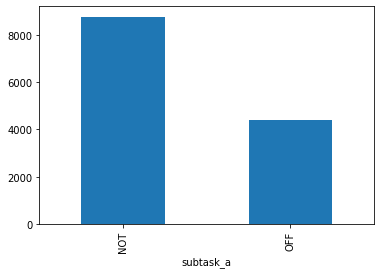

In [0]:
print('Subtask A categories',df_tweet['subtask_a'].unique())
print('Subtask A offensive tweet count',df_tweet[df_tweet['subtask_a']=='OFF'].subtask_a.count())
print('Subtask A Non offensive tweet count',df_tweet[df_tweet['subtask_a']=='NOT'].subtask_a.count())
print('Total trainable tweets',df_tweet['subtask_a'].count())
df_tweet.groupby(['subtask_a']).count()['id'].plot.bar()

Subtask B categories ['UNT' 'TIN' nan] total
Subtask B untargetted offensive tweet count  524
Subtask B targetted offensive tweet count 3875
Subtask B Non offensive tweet count 8789
Subtask B Total trainable tweets 4399


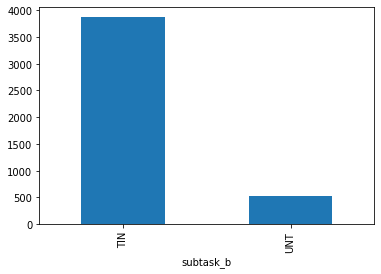

In [0]:
print('Subtask B categories',df_tweet['subtask_b'].unique(),'total')
print('Subtask B untargetted offensive tweet count ',df_tweet[df_tweet['subtask_b']=='UNT'].subtask_b.count())
print('Subtask B targetted offensive tweet count',df_tweet[df_tweet['subtask_b']=='TIN'].subtask_b.count())
print('Subtask B Non offensive tweet count',df_tweet['subtask_b'].isnull().sum())
print('Subtask B Total trainable tweets',df_tweet['subtask_b'].isin(['UNT','TIN']).sum())
df_tweet.groupby(['subtask_b']).count()['id'].plot.bar()

Subtask C categories [nan 'IND' 'OTH' 'GRP']
Subtask C targetted indiviual offensive tweet count 2406
Subtask C targetted group offensive tweet count 1074
Subtask C targetted other offensive tweet count 395
Subtask C Non offensive tweet count 9313
Subtask C Total trainable tweets 3875


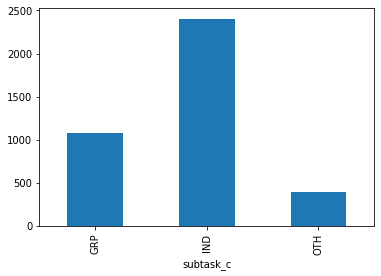

In [0]:
print('Subtask C categories',df_tweet['subtask_c'].unique())
print('Subtask C targetted indiviual offensive tweet count',df_tweet[df_tweet['subtask_c']=='IND'].subtask_c.count())
print('Subtask C targetted group offensive tweet count',df_tweet[df_tweet['subtask_c']=='GRP'].subtask_c.count())
print('Subtask C targetted other offensive tweet count',df_tweet[df_tweet['subtask_c']=='OTH'].subtask_c.count())
print('Subtask C Non offensive tweet count',df_tweet['subtask_c'].isnull().sum())
print('Subtask C Total trainable tweets',df_tweet['subtask_c'].isin(['IND','GRP','OTH']).sum())
df_tweet.groupby(['subtask_c']).count()['id'].plot.bar()

# Model Building - Task A

The first task is to mark the tweet as being offensive or not offensive. Below are the steps followed
1. read the stage 2 preprocessed tweet data
2. convert the data into train, test and train_labels and test_labels
3. create a LSTM network
    3.1 build glove embedding layer
4. fit the train, train_labels to the network
5. evaluate the results

Same steps are carried out for CNN model also.

In [0]:
import pandas as pd
import numpy as np
df_tweet = pd.read_csv("data/processed_tweet2.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st2),axis =1)

In [0]:
#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others

df_tweet['subtask_a'] = df_tweet.apply(lambda x: 0 if x.subtask_a=='NOT' else 1,axis = 1)

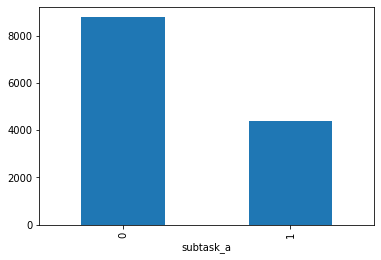

In [3]:
# visvualise the distribution
df_tweet.groupby(['subtask_a']).count()['id'].plot.bar()

## Readying the inputs for Model 
word_ids - unique word vocab

word2idx,- word -> index

idx2word, - index -> word

and sents_as_ids -> sentence in form of index

In [0]:
normalised_corpus = list(df_tweet['tweet_pr_st2'])
labels = list(df_tweet['subtask_a'])

In [0]:
import collections, itertools
word_counter = collections.Counter(list(itertools.chain.from_iterable(normalised_corpus)))

In [6]:
word_ids = list(set(list(itertools.chain.from_iterable(normalised_corpus))))
print("Unique number of words",len(word_ids))

Unique number of words 13910


In [0]:
word2idx = {}
word2idx = {token:id+3 for id,token in enumerate(word_ids)}
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

In [0]:
idx2word = {v: k for k,v in word2idx.items()}

In [0]:
sents_as_ids = []
for i in range(len(normalised_corpus)):
    sents_as_ids.append([word2idx[j] for j in normalised_corpus[i]])

In [0]:
vocab_size = len(word_ids) + 3
maxlen=50

In [11]:
from keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
def readGloveFile(gloveFile):
    '''
    read the glove vector and return 
    input: gloveFile, string, path of file
    return: wordToIndex, indexToWord, wordToGlove, embeddings
    '''
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [0]:
def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    '''
    create embedding layer and return using the glove vectors
    '''
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable)
    return embeddingLayer

In [0]:
#test - train 20-80 split
train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

# ecnoding the train and test data with padding '00' at the end
X_train_enc = pad_sequences(train_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=maxlen)
X_test_enc = pad_sequences(test_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=maxlen)

#### if glove.6B.zip does not exist please uncomment the below,
#### for simplicity it should exist in current working dir 

In [16]:
# !pip install chakin
# import chakin
# chakin.download(number=12, save_dir='./')

# import os
# os.system("unzip './glove.6B.zip' ")
# # os.system("rm './glove.6B.zip'")

Test: 100% ||                                      | Time:  0:06:29   2.1 MiB/s


0

Build the embedding layer

In [15]:
from tensorflow.contrib.keras.api.keras.initializers import Constant
wordToIndex, indexToWord, wordToGlove = readGloveFile('glove.6B.300d.txt')
embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True)

### LSTM model Part A

In [49]:
model1 = Sequential()
EMBED_SIZE = 100
model1.add(embeddingLayer)
model1.add(Dropout(0.2))
model1.add(LSTM(100, activation='tanh'))
model1.add(Dropout(0.2))
model1.add(Dense(1,activation='sigmoid',input_shape=(1,)))
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [17]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model1.fit(X_train_enc,
                    train_labels,
                    epochs=7,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8440 samples, validate on 2110 samples
Epoch 1/7




/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)





8440/8440 [==============================] - 27s 3ms/step - loss: 0.6435 - acc: 0.6600 - val_loss: 0.6260 - val_acc: 0.6829
Epoch 2/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6389 - acc: 0.6564 - val_loss: 0.6146 - val_acc: 0.6829
Epoch 3/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6334 - acc: 0.6692 - val_loss: 0.6225 - val_acc: 0.6858
Epoch 4/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6254 - acc: 0.6832 - val_loss: 0.6242 - val_acc: 0.6943
Epoch 5/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6340 - acc: 0.6743 - val_loss: 0.6230 - val_acc: 0.6867
Epoch 6/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6391 - acc: 0.6654 - val_loss: 0.6280 - val_acc: 0.6867
Epoch 7/7
8440/8440 [==============================] - 20s 2ms/step - loss: 0.6374 - acc: 0.6662 - val_loss: 0.6223 - val_acc: 0.6867


In [18]:
results = model1.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 1s 476us/step
[0.629784188594124, 0.673616376132835]


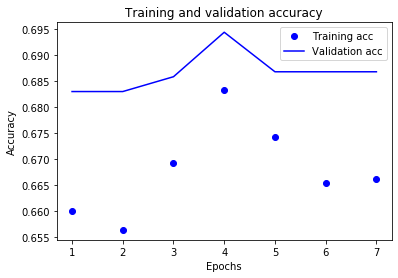

In [19]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Thus, LSTM model performance is very average with large validation error. We can see large overfitting in the network.

### CNN model Part A

In [50]:
model2 = Sequential()
embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True)
model2.add(embeddingLayer)
model2.add(Dropout(0.2))
model2.add(Convolution1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=4))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 120,162,465
Trainable params: 120,162,465
Non-trainable params: 0
________________________________________

In [21]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model2.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=256,
                    validation_split=0.2,
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 8440 samples, validate on 2110 samples
Epoch 1/5
8440/8440 [==============================] - 12s 1ms/step - loss: 0.6371 - acc: 0.6591 - val_loss: 0.6015 - val_acc: 0.6877
Epoch 2/5
8440/8440 [==============================] - 3s 412us/step - loss: 0.5245 - acc: 0.7430 - val_loss: 0.5720 - val_acc: 0.7346
Epoch 3/5
8440/8440 [==============================] - 3s 409us/step - loss: 0.4041 - acc: 0.8268 - val_loss: 0.5900 - val_acc: 0.7526
Epoch 4/5
8440/8440 [==============================] - 3s 412us/step - loss: 0.3209 - acc: 0.8697 - val_loss: 0.6049 - val_acc: 0.7597
Epoch 5/5
8440/8440 [==============================] - 3s 411us/step - loss: 0.2481 - acc: 0.9076 - val_loss: 0.6929 - val_acc: 0.7275


In [22]:
results = model2.evaluate(X_test_enc, test_labels)
print(results)

2638/2638 [==============================] - 0s 178us/step
[0.6717062422142868, 0.739575436026694]


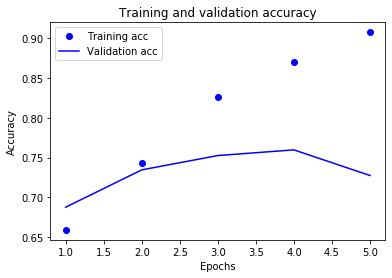

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Thus, CNN performance can be improved by laying out better architurere as we can see although a ver good accuracy is obtained but the model is highly over fitted.

# Model Building - Task B

In this task we have to not only identify the Offnsive (OFF) and not offensive (NOT) tweet but also if the the tweet is directed or not and if it is then if it directed to an individual, group or others

In [0]:
import pandas as pd
import numpy as np
df_tweet = pd.read_csv("data/processed_tweet2.csv")
import ast
df_tweet['tweet_pr_st1'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st1),axis =1)
df_tweet['tweet_pr_st2'] = df_tweet.apply(lambda x: ast.literal_eval(x.tweet_pr_st2),axis =1)

def conditions(x):
    '''
    coverting the data to more usuable form
    'NOT' -> 0
    'OFF-UNT' - > 1
    'TIN-OFF-IND' -> 2
    'TIN-OFF-GRP' -> 3
    'TIN-OFF-OTH' -> 4
    ''
    '''
    if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='IND'):
        return 2
    elif (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='GRP'): 
        return 3
    elif (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c =='OTH'):
        return 4        
    elif (x.subtask_a=='OFF' and x.subtask_b=='UNT'):
        return 1
    else:
        return 0
    # return 2 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='IND') else 3 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c=='GRP') else 4 if (x.subtask_b=='TIN' and x.subtask_a=='OFF' and x.subtask_c =='OTH') else 1 if (x.subtask_a=='OFF' and x.subtask_b=='UNT') else 0

df_tweet['subtask_c'] = df_tweet.apply(conditions,axis=1)

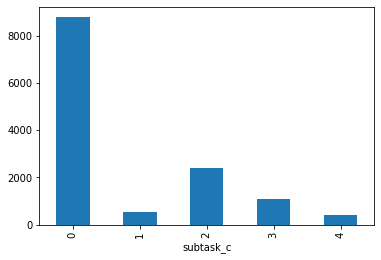

In [17]:
# visualising the distribution
df_tweet.groupby(['subtask_c']).count()['id'].plot.bar()

In [0]:
labels = list(df_tweet['subtask_c'])

In [0]:
# converting the labels to onehot encoded form
def one_hot(labels):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder()
    return encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

labels = one_hot(labels)

In [0]:
from sklearn.model_selection import train_test_split
train_data,test_data,train_labels,test_labels = train_test_split(sents_as_ids,labels,test_size=0.2,stratify=labels)

X_train_enc = pad_sequences(train_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)
X_test_enc = pad_sequences(test_data,
                            value=word2idx["<PAD>"],
                            padding='post',
                            maxlen=50)

In [21]:
model3 = Sequential()
EMBED_SIZE = 100
embeddingLayer = createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable=True)
model3.add(embeddingLayer)
model3.add(Dropout(0.08))
model3.add(LSTM(100, activation='tanh'))
model3.add(Dropout(0.08))
model3.add(Dense(train_labels.shape[1],activation='softmax'))
model3.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 120,161,205
Trainable params: 120,161,205
Non-trainable params: 0
______________________________________________________

In [22]:
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model3.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8440 samples, validate on 2110 samples
Epoch 1/5




/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)





8440/8440 [==============================] - 36s 4ms/step - loss: 0.3513 - acc: 0.8615 - val_loss: 0.3359 - val_acc: 0.8693
Epoch 2/5
8440/8440 [==============================] - 20s 2ms/step - loss: 0.3418 - acc: 0.8658 - val_loss: 0.3344 - val_acc: 0.8693
Epoch 3/5
8440/8440 [==============================] - 20s 2ms/step - loss: 0.3291 - acc: 0.8729 - val_loss: 0.3233 - val_acc: 0.8809
Epoch 4/5
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2898 - acc: 0.8914 - val_loss: 0.3175 - val_acc: 0.8861
Epoch 5/5
8440/8440 [==============================] - 20s 2ms/step - loss: 0.2571 - acc: 0.9033 - val_loss: 0.3310 - val_acc: 0.8713


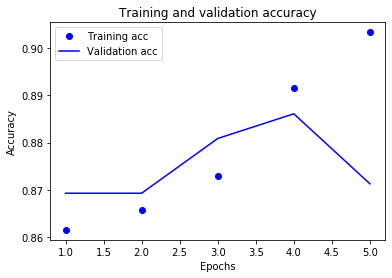

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
model4 = Sequential()
model4.add(embeddingLayer)
# model4.add(Convolution1D(64,5,activation="relu"))
# model4.add(Dropout(0.5))
# model4.add(Convolution1D(32,3,activation="relu"))
# model4.add(Dropout(0.5))
# model4.add(Convolution1D(16,3,activation="sigmoid"))
# model4.add(MaxPooling1D(5))
# model4.add(Flatten())
# model4.add(Dense(train_labels.shape[1],activation='softmax'))
# model4.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model4.add(Dropout(0.2))
model4.add(Convolution1D(64, 5, activation='relu'))
model4.add(MaxPooling1D(pool_size=4))
model4.add(LSTM(100))
model4.add(Dense(train_labels.shape[1],activation='softmax'))
model4.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 300)         120000300 
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 120,162,869
Trainable params: 120,162,869
Non-trainable params: 0
_______________________________________

In [26]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# X_val = np.array(X_train_enc[:10000])
# partial_X_train = np.array(X_train_enc[10000:])

history = model4.fit(X_train_enc,
                    train_labels,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:421: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 120000300 elements. This may consume a large amount of memory.
  num_elements)


Train on 8440 samples, validate on 2110 samples
Epoch 1/5
8440/8440 [==============================] - 21s 3ms/step - loss: 0.3050 - acc: 0.8812 - val_loss: 0.3101 - val_acc: 0.8871
Epoch 2/5
8440/8440 [==============================] - 13s 2ms/step - loss: 0.2304 - acc: 0.9109 - val_loss: 0.3246 - val_acc: 0.8779
Epoch 3/5
8440/8440 [==============================] - 13s 2ms/step - loss: 0.2104 - acc: 0.9183 - val_loss: 0.3491 - val_acc: 0.8771
Epoch 4/5
8440/8440 [==============================] - 13s 2ms/step - loss: 0.1913 - acc: 0.9257 - val_loss: 0.3563 - val_acc: 0.8852
Epoch 5/5
8440/8440 [==============================] - 13s 2ms/step - loss: 0.1728 - acc: 0.9337 - val_loss: 0.3753 - val_acc: 0.8733


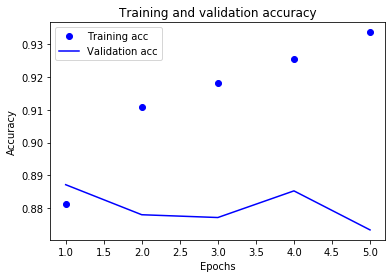

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()